In [1]:
%load_ext autoreload
%autoreload 2

# Analyse the traffic information in screenshots from Google maps

In [2]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import re
from pprint import pprint
from traffic_analysis import (
    display_shot,
    load_config,
    maximum_measure_points,
    get_colors_from_screenshots,
    show_points_on_screenshot,
)

In [71]:
# Directory where the screenshots are stored
URL_IMAGE_DIR = "shots"
url_image_dir = Path(URL_IMAGE_DIR)
assert url_image_dir.exists()

# Which street to analyse and in what direction
LOCATION = "leuven"
STREET = "tiensestraat"
DIRECTION = "to" # must be "to"the crossing or away "from" the crossing

# config file in TOML format that contains the URL's for the screenshots
CONFIG_FILE = "config.toml"
assert Path(CONFIG_FILE).exists()

In [72]:
# Get the URL of the first image on the LOCATION and STREET

url_image = next(url_image_dir.glob(f"{LOCATION}_{STREET}_*.png"))
assert url_image.exists()
url_image

PosixPath('shots/leuven_tiensestraat_20231017-180213.png')

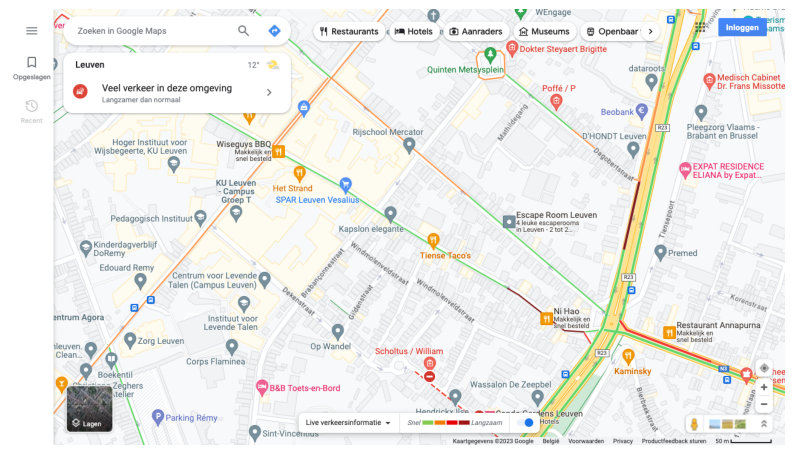

In [73]:
ax = display_shot(url_image)
plt.show()

In [74]:
config = load_config(CONFIG_FILE)

# Print the values
pprint(config[LOCATION][STREET])

{'points_to': [[946, 532],
               [916, 531],
               [873, 498],
               [828, 464],
               [811, 455],
               [742, 415],
               [712, 398],
               [685, 382],
               [610, 336],
               [584, 319],
               [561, 303],
               [537, 288],
               [465, 248],
               [404, 214],
               [340, 178]],
 'url': 'https://www.google.com/maps/@50.8748008,4.7106216,17z/data=!5m1!1e1'}


In [75]:
streets = list(config[LOCATION].keys())
streets

['geldenaaksevest', 'tiensevest', 'tiensesteenweg', 'tiensestraat']

In [76]:
assert (
    f"points_{DIRECTION}" in config[LOCATION][STREET].keys()
), f"Found no points to sample from, add [[x0, y0], ..., [xn, yn]] in key points_{DIRECTION} in {LOCATION}.{STREET}"

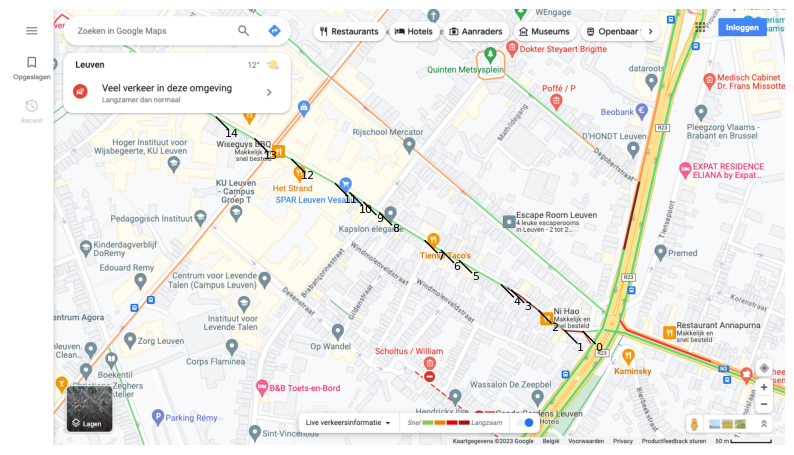

In [77]:
# Plot the points where to measure traffic flow

ax = show_points_on_screenshot(
    config,
    LOCATION,
    STREET,
    url_image,
    direction=DIRECTION,
    x_text_offset=-6,
    x_line_offset=-20,
)

plt.savefig(
    f"figs/meetpunten_{LOCATION}_{STREET}_{DIRECTION}.png",  # Set path and filename
    dpi=300,  # Set dots per inch
    bbox_inches="tight",  # Remove extra whitespace around plot
    facecolor="white",
)
plt.show()

In [78]:
number_of_points = len(config[LOCATION][STREET][f"points_{DIRECTION}"])
print(f"The number of points to measure is")
print(f"{number_of_points=} in {LOCATION=} {STREET=} {DIRECTION=}")

The number of points to measure is
number_of_points=15 in LOCATION='leuven' STREET='tiensestraat' DIRECTION='to'


# Walk over screenshots and sample pixel colors

In [79]:
number_of_points, _, _, _ = maximum_measure_points(config)
number_of_points

69

In [80]:
df = get_colors_from_screenshots(
    config, url_image_dir, location=LOCATION, street=STREET, direction=DIRECTION
)

df.head()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,...,color_67,p67_red,p67_green,p67_blue,traffic_color_67,color_68,p68_red,p68_green,p68_blue,traffic_color_68
27,leuven,geldenaaksevest,shots/leuven_geldenaaksevest_20231017-114230.png,2023-10-17 11:42:30,"[255, 151, 77]",255,151,77,orange,"[255, 151, 77]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
49,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-114236.png,2023-10-17 11:42:36,"[255, 151, 77]",255,151,77,orange,"[255, 151, 77]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
96,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,2023-10-17 11:42:39,"[243, 70, 61]",243,70,61,grey,"[242, 60, 50]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
36,leuven,geldenaaksevest,shots/leuven_geldenaaksevest_20231017-114534.png,2023-10-17 11:45:34,"[255, 151, 77]",255,151,77,orange,"[255, 151, 77]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
51,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-114540.png,2023-10-17 11:45:40,"[255, 151, 77]",255,151,77,orange,"[255, 151, 77]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey


In [81]:
df.tail()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,...,color_67,p67_red,p67_green,p67_blue,traffic_color_67,color_68,p68_red,p68_green,p68_blue,traffic_color_68
66,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,2023-10-17 18:02:10,"[242, 60, 50]",242,60,50,red,"[242, 60, 50]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
78,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,2023-10-17 18:02:13,"[136, 43, 43]",136,43,43,grey,"[129, 31, 31]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
11,leuven,geldenaaksevest,shots/leuven_geldenaaksevest_20231017-180716.png,2023-10-17 18:07:16,"[242, 60, 50]",242,60,50,red,"[242, 60, 50]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
48,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180722.png,2023-10-17 18:07:22,"[242, 60, 50]",242,60,50,red,"[242, 60, 50]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
105,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180725.png,2023-10-17 18:07:25,"[243, 70, 61]",243,70,61,grey,"[242, 60, 50]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey


## Inspect the dataframe

In [82]:
df["street"].value_counts()

street
geldenaaksevest    39
tiensesteenweg     39
tiensestraat       39
Name: count, dtype: int64

## Display all colors that are found in the dataframe

In [83]:
# Create a set with all unique colors in the color columns
unique_colors = {color for column in  df.filter(regex='^color_').columns for color in df[column].astype(str).unique()}
print(f"There are {len(unique_colors)} in found")
print("All unique colors:")
print(", ".join(unique_colors))

There are 26 in found
All unique colors:
[243  70  61], [104 215 109], [118 219 122], [153 228 156], [165 231 167], [255 198 157], [248 148 142], [255 181 128], [255 169 107], [121 220 126], [255 156  86], [136  43  43], [253 226 147], [247 142 136], [ 99 214 104], [244  93  85], [255 201 163], [129  31  31], [147 227 150], [255 151  77], [144 226 148], [128, 128, 128], [242  60  50], [140 225 144], [255 195 152], [107 216 112]


In [84]:
# Create a grid of colors
number_of_colors = len(unique_colors)
mosaic = [[f"color_{3*i}", f"color_{3*i+1}", f"color_{3*i+2}"] for i in range(1+number_of_colors//3)]
mosaic

[['color_0', 'color_1', 'color_2'],
 ['color_3', 'color_4', 'color_5'],
 ['color_6', 'color_7', 'color_8'],
 ['color_9', 'color_10', 'color_11'],
 ['color_12', 'color_13', 'color_14'],
 ['color_15', 'color_16', 'color_17'],
 ['color_18', 'color_19', 'color_20'],
 ['color_21', 'color_22', 'color_23'],
 ['color_24', 'color_25', 'color_26']]

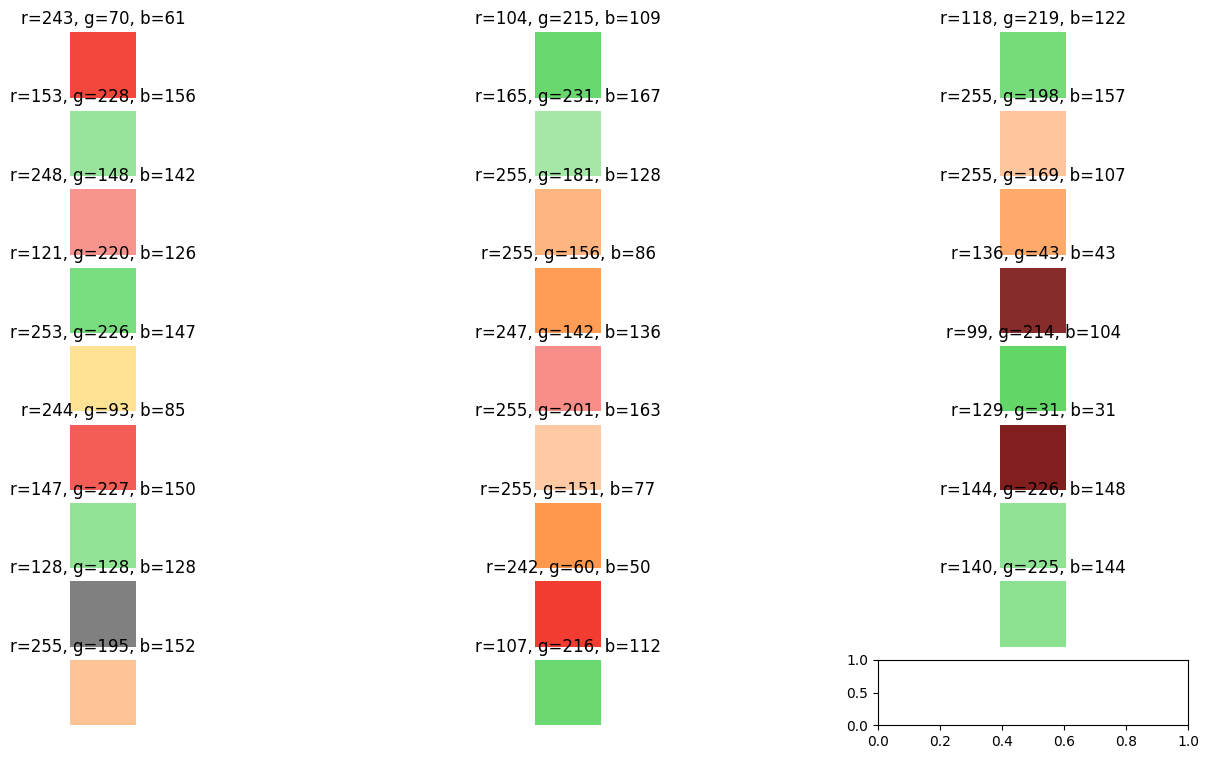

In [85]:
fig, axd = plt.subplot_mosaic(
    mosaic, gridspec_kw={"width_ratios": [1, 1, 1], "wspace": 0.5}, figsize=(16, 9)
)
assert number_of_colors < len(
    fig.axes
), "Increase the number of axis {len(fig.axes)} to at least {number_of_colors=}"
for idx, (color, ax) in enumerate(
    zip(unique_colors, fig.axes)
):
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r"\d+", color)
    # print (numbers[0], numbers[1], numbers[2])
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    ax.set_axis_off()
    if idx < number_of_colors:
        ax.imshow([[(r, g, b)]])
        ax.set_title(f"{r=}, {g=}, {b=}")

# Analyse/resample the data and make plot

In [86]:
df = df.sort_values(by="timestamp").reset_index(drop=True).copy()

In [87]:
df["street"].shape

(117,)

In [88]:
df["street"].value_counts()

street
geldenaaksevest    39
tiensesteenweg     39
tiensestraat       39
Name: count, dtype: int64

In [89]:
df_resampled = df.query(f"(street == '{STREET}')").set_index("timestamp").resample("1Min").ffill()

In [90]:
df_resampled["street"].value_counts()

street
tiensestraat    385
Name: count, dtype: int64

In [91]:
# Remove the first row from the dataframe
df_resampled = df_resampled.reset_index().iloc[1:].set_index("timestamp")
df_resampled.head()

,location,street,path,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,p1_red,...,color_67,p67_red,p67_green,p67_blue,traffic_color_67,color_68,p68_red,p68_green,p68_blue,traffic_color_68
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 11:43:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:44:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:45:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:46:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114543.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:47:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114543.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey


## Analyse the STREET

In [92]:
df_resampled["street"].value_counts()

street
tiensestraat    385
Name: count, dtype: int64

In [93]:
df_street = df_resampled[df_resampled.index > "2023-10-17 15:29:00"]

In [94]:
df_street.shape

(158, 348)

In [95]:
df_street

,location,street,path,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,p1_red,...,color_67,p67_red,p67_green,p67_blue,traffic_color_67,color_68,p68_red,p68_green,p68_blue,traffic_color_68
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 15:30:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:31:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:32:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:33:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:34:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[243, 70, 61]",243.0,70.0,61.0,grey,"[242, 60, 50]",242.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17 18:03:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[136, 43, 43]",136.0,43.0,43.0,grey,"[129, 31, 31]",129.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 18:04:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[136, 43, 43]",136.0,43.0,43.0,grey,"[129, 31, 31]",129.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 18:05:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[136, 43, 43]",136.0,43.0,43.0,grey,"[129, 31, 31]",129.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey


### Plot trafic density with matplotlib

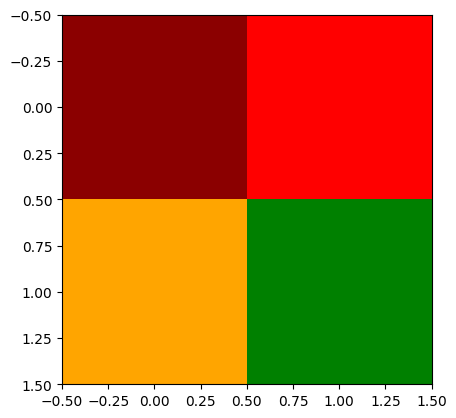

In [96]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkred", "red", "orange", "green"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

plt.imshow([[0, 1], [2, 3]], cmap=cmap)
plt.show()

In [97]:
df_street.shape

(158, 348)

In [98]:
number_of_points = len(config[LOCATION][STREET][f"points_{DIRECTION}"]) 
color_columns = [f"traffic_color_{i}" for i in range(number_of_points)]
color2index = {"darkred": 0, "red": 1, "orange": 2, "green": 3}
index_columns = []
df_matrix = df_street.copy()
for idx, colom in enumerate(color_columns):
    df_matrix.loc[:, f"index_color_{idx}"] = df_street[colom].map(color2index).values
    index_columns.append(f"index_color_{idx}")
traffic_color_matrix = df_matrix[index_columns].fillna(3).to_numpy()
traffic_color_matrix

array([[3., 1., 1., ..., 3., 2., 2.],
       [3., 1., 1., ..., 3., 2., 2.],
       [3., 1., 1., ..., 3., 2., 2.],
       ...,
       [3., 0., 0., ..., 3., 3., 3.],
       [3., 0., 0., ..., 3., 3., 3.],
       [3., 0., 0., ..., 3., 3., 3.]])

In [99]:
traffic_color_matrix.shape

(158, 15)

In [100]:
from matplotlib.text import Text
import matplotlib.dates as mdates

In [101]:
time = df_street.index

In [102]:
traffic_color_matrix.shape

(158, 15)

/var/folders/l3/cl401yld1x3f35c0g3sbm3b80000gp/T/ipykernel_10241/2341836912.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


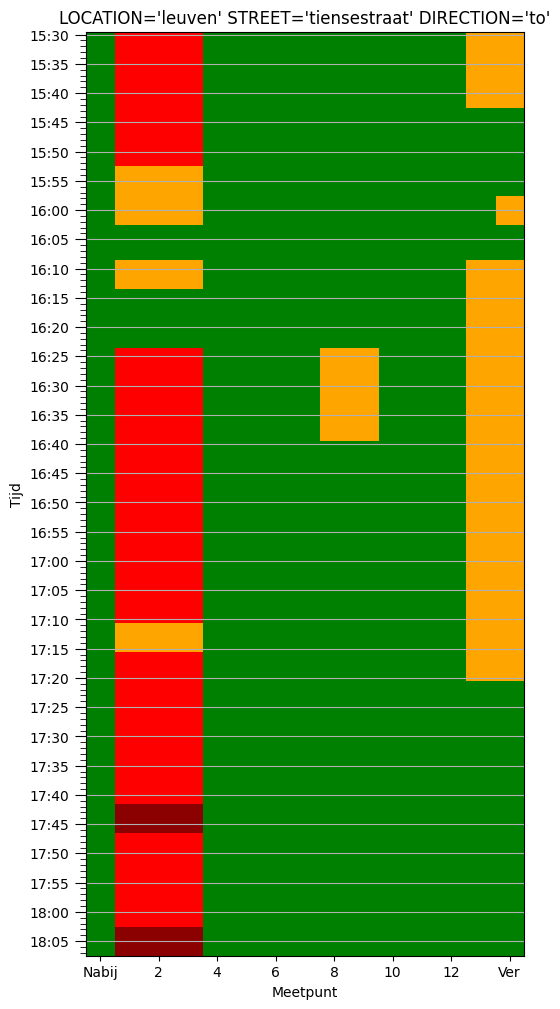

In [103]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_xlabel("Meetpunt")
ax.set_ylabel("Tijd")

ticks = df_street.index
tick_labels = [
    f"{tick:%H:%M}" if idx % 5 == 0 else "" for idx, tick in enumerate(ticks)
]
major_tick_labels = [f"{tick:%H:%M}" for idx, tick in enumerate(ticks) if idx % 5 == 0]

# Plot the matrix using imshow on the specified axis
ax.imshow(traffic_color_matrix, cmap=cmap, aspect=0.2)

# Set y-axis tick locations and labels
ax.set_yticks(list(range(df_street.shape[0])), minor=True)
ax.set_yticks(list(range(0, df_street.shape[0], 5)), minor=False)
ax.set_yticklabels(major_tick_labels, minor=False)

# Customize tick parameters to make major ticks longer
ax.tick_params(axis="y", which="major", size=8)  # Adjust the size as needed
ax.tick_params(axis="y", which="minor", size=4)

# Add gridlines for the y-axis at major y-tick positions
ax.yaxis.grid(True, which="major")

# Hide gridlines for the x-axis
ax.xaxis.grid(False)

xlabels = ax.get_xticklabels()
for idx, label in enumerate(xlabels):
    # xlabels[idx].set_text('')
    if idx == 1:
        xlabels[1].set_text("Nabij")
    if idx == len(xlabels) - 1:
        xlabels[-2].set_text("Ver")
ax.set_xticklabels(xlabels)
ax.set_title(f"{LOCATION=} {STREET=} {DIRECTION=}")


plt.savefig(
    f"figs/{LOCATION}_{STREET}_231017_16u_18u_{DIRECTION}.png",  # Set path and filename
    dpi=300,  # Set dots per inch
    bbox_inches="tight",  # Remove extra whitespace around plot
    facecolor="white",
)  # Set background color to white